#시스템 품질 변화로 인한 사용자 불편 예지 AI 경진대회
#LG | 채용 | 시스템 | 사용자 불편 | 정형 | AUC
https://colab.research.google.com/drive/1YwV0B1fS_Y2XHculQWZWKxYfuC9aKQ4d#scrollTo=BCrVghdxUeD8
## 목차
### 1. Library Import
### 2. 학습데이터 생성
### 3. Light-gbm 모델 훈련
### 4. 교차 검증 점수 확인
### 5. 제출 파일 생성

# 1. Library Import

In [ ]:

import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/', nb_path) 
sys.path.insert(0, nb_path)

Drive already mounted at /content/mnt; to attempt to forcibly remount, call drive.mount("/content/mnt", force_remount=True).


FileExistsError: ignored

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import tensorflow as tf
import string
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Activation, Dropout, Flatten, Dense,Softmax, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import warnings
warnings.filterwarnings(action='ignore')





# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    #print("x="+x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #print(year,month,day,hour)
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour) #20201130190653

def string2num(x):
    # (,)( )과 같은 불피요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)

PATH='/content/mnt/MyDrive/Colab Notebooks/'
#PATH = '/content/'

# 2. 학습 데이터 생성

## 2.1 train_err

* train_err_data.csv 파일의 errtype column의 value_counts를 카운트하여 학습에 사용.  
* 주어진 기간동안 user_id별로 peroblem가 한 번이라도 발생했는 지를 확인.  

In [ ]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
display(train_err.head(-5))

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0
...,...,...,...,...,...,...
16554653,24999,20201130074711,model_3,05.15.2138,4,0
16554654,24999,20201130142105,model_3,05.15.2138,15,1
16554655,24999,20201130161510,model_3,05.15.2138,16,1
16554656,24999,20201130161511,model_3,05.15.2138,4,0


In [ ]:
# 데이터 설명을 확인하면
# ueser_id가 10000부터 24999까지 총 15000개가 연속적으로 존재.
display(train_err.head())
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [ ]:
#참고) 일별 합산 데이터 생성 코드      
import datetime
#train_err = pd.read_csv(PATH+'train_err_data.csv')
train_err['datetime']=pd.to_datetime(train_err['time'])
#train_err['time']
#train_err['time'][0]
#print(train_err['time'])
train_err['datetime'] = train_err['time'].apply(make_datetime)
print(train_err['datetime'][1])
if(train_err['datetime'][0]<train_err['datetime'][1]+datetime.timedelta(hours=1)):
    print("true")


2020-11-01 03:00:00
true


In [ ]:
errdic={}
errdic[1]=0
errdic[2]=1
errdic[3]=2
errdic[4]=3
errdic[5]=4
errdic[6]=5
errdic[8]=6
errdic[9]=7
errdic[10]=8
errdic[13]=9
errdic[14]=10
errdic[15]=11
errdic[17]=12
errdic[18]=13
errdic[19]=14
errdic[22]=15
errdic[24]=16
errdic[25]=17
errdic[26]=18
errdic[27]=19
errdic[30]=20
errdic[31]=21
errdic[32]=22
errdic[33]=23
errdic[34]=24
errdic[36]=25
errdic[38]=26
errdic[39]=27
errdic[40]=28
errdic[41]=29
errdic[42]=30
print(errdic)
print(errdic[8])
a=29
if (a in errdic):
    print(errdic[a])

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 8: 6, 9: 7, 10: 8, 13: 9, 14: 10, 15: 11, 17: 12, 18: 13, 19: 14, 22: 15, 24: 16, 25: 17, 26: 18, 27: 19, 30: 20, 31: 21, 32: 22, 33: 23, 34: 24, 36: 25, 38: 26, 39: 27, 40: 28, 41: 29, 42: 30}
6


In [ ]:
st='04.33.1149'
la=st.split(".")
print(la)
for i in la:
    if( int(i) ==10):
        print(int(i)*100)
        break
    print(int(i))

def fwwitherr(fwv,errt):
    la=fwv.split(".")
    sum=0
    for i in range(len(la)):
        if i==2:
            return sum*100+errt
        if( int(la[i]) == 10 and i==0):
            return 10000+errt
        sum+= int(la[i])* (100**(1-i))
        
    return sum*100+errt
def fwint(fwv):
    la=fwv.split(".")
    return int(la[0])
print(fwwitherr(st,42))
print(fwint(st))

['04', '33', '1149']
4
33
1149
43342
4


In [ ]:
import itertools
a=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
npr=itertools.permutations(a,3)
ac=list(npr)
#print(len(ac)) 990개 색깔
#plt.plot([1,2,3,4],c=ac[989])


In [ ]:
train_qual = pd.read_csv(PATH+'train_quality_data.csv',thousands=',')
train_qual['datetime'] = train_qual['time'].apply(make_datetime)

id_qual=train_qual[['user_id','datetime','fwver','quality_0','quality_1','quality_2','quality_3','quality_4','quality_5','quality_6','quality_7','quality_8','quality_9','quality_10','quality_11','quality_12']].values
qualili=np.zeros((15000,14))
cnt=0

curuser=10000
cnt=0
#qualist=([10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,-500,-500,-500,-500,-500,-500,-500,-500,-500,-500,-500,-500,-500])*15000
qualist=np.zeros((15000,26))
for i in qualist:
    for j in range(13):
        i[j]=100000000
    for j in range(13,26):
        i[j]=-500

min=1000000000
max=-500
for j in tqdm(id_qual):
    if curuser==j[0]:
        for i in range(3,16):
          if( qualist[curuser-10000][i-3]>j[i]):
              qualist[curuser-10000][i-3]=j[i]
          elif (qualist[curuser-10000][i-3+13]<j[i]):
              qualist[curuser-10000][i-3+13]=j[i]
    else:
        curuser=j[0]
        for i in range(3,16):
          if( qualist[curuser-10000][i-3]>j[i]):
              qualist[curuser-10000][i-3]=j[i]
          elif (qualist[curuser-10000][i-3+13]<j[i]):
              qualist[curuser-10000][i-3+13]=j[i]

#for user,dat,fw,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12 in tqdm(id_qual):
print(curuser)
newqualist=np.zeros((15000,13))
for i in range(15000):
    for j in range(13):
        if (qualist[i][j+13]-qualist[i][j] <-5000): #초기값
            continue
        else:
            newqualist[i][j]=qualist[i][j+13]-qualist[i][j]

   



100%|██████████| 828624/828624 [00:14<00:00, 55493.73it/s]


24997


In [ ]:
person,timeid=id_qual[0][0],id_qual[0][1]
person,timeid
print(person,timeid)
ab=[]
#print(id_errtime[0],id_errtime[500])# 10000 번째, 10001번쨰 두명있네.
curuser=10000
first=0
last=0
cnt=0
idqualarr=[]
for user,dat,fw,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12 in tqdm(id_qual):
    if (curuser==user):
        last=cnt
    else:
        li=[]
        li.append(first)
        li.append(last)        
        idqualarr.append(li)
        ab.append(curuser)
        for i in range(curuser+1,user):
            idqualarr.append([])
            ab.append(i)
        first=cnt
        curuser=user
    cnt+=1
li=[]
li.append(first)
li.append(last)
idqualarr.append(li)
idqualarr.append([])
idqualarr.append([])




  7%|▋         | 54863/828624 [00:00<00:01, 548629.22it/s]

10000 2020-11-29 09:00:00


100%|██████████| 828624/828624 [00:01<00:00, 597621.75it/s]


In [ ]:
li5=['B-A8002', 'Q-64002', 'S-61001', 'U-81009', 'V-21008', '700001', 'S-64002', 'J-30021', 'S-65002', 'Q-64001', 'H-51042', 'C-11017', 'H-51046', 'H-51049', 'V-21002', 'V-21003', 'V-21004', 'V-21005', 'B-51042', 'M-99999', 'U-82024', 'H-51048', '60045', 'U-82026', 'C-13053', 'En00409']
len(li5)

26

In [ ]:
# user_id와 errtype만을 사용하여 데이터 셋 생성
# 모든 일자에 대해서 errtype별 발생 건수를 count
# pandas의 groupby를 활용할 경우 큰 연산 자원이 필요.
# numpy로 placeholder를 만들어 구현함.
import copy
id_error = train_err[['user_id','datetime','fwver','errtype','errcode']].values
error = np.zeros((train_user_number,152)) #15000,42 의 0배열 생성.
#errorreduc=np.zeros((train_user_number,32))
minnum=317
curuser=10000
#errstrli=np.zeros((train_user_number,1),dtype="object")

#errli=np.empty((train_user_number,1),dtype="object")
sum=0
allnum=0
color=0
temp=[]
#usid,dtime,fw,erty,errco
cnt=0
li16=['80', '79', '81', '78', '85', '84', '90', '89', '88', '95', '94', '91', '83', '86', '87', '82', '93', '77', '75', '76', '96', '92', '100']
li5=['B-A8002', 'Q-64002', 'S-61001', 'U-81009', 'V-21008', '700001', 'S-64002', 'J-30021', 'S-65002', 'Q-64001', 'H-51042', 'C-11017', 'H-51046', 'H-51049', 'V-21002', 'V-21003', 'V-21004', 'V-21005', 'B-51042', 'M-99999', 'U-82024', 'H-51048', '60045', 'U-82026', 'C-13053', 'En00409']

for person_idx,dtime,fw,err,errco in tqdm(id_error):
    #print(person_idx)
    if err==23:
        if errco.strip() in ['standby']:
            error[person_idx-train_user_id_min,42]+=1
        elif errco.strip() in ['connection fail to establish']:
            error[person_idx-train_user_id_min,28]+=1
        elif errco.strip() in ['connection timeout']:
            error[person_idx-train_user_id_min,43]+=1
        elif errco.strip() in ['active']:
            error[person_idx-train_user_id_min,44]+=1
        elif errco.strip() in ['connectionterminated by local host']:
            error[person_idx-train_user_id_min,45]+=1
        elif errco.strip() in ['terminate by peer user']:
            error[person_idx-train_user_id_min,46]+=1
    elif err==31:
        if str(errco).strip() in ['1']:
            error[person_idx-train_user_id_min,47]+=1
        if str(errco).strip() in ['0']:
            error[person_idx-train_user_id_min,48]+=1
    elif err==4:
        if str(errco).strip() in ['0']:
            error[person_idx-train_user_id_min,49]+=1
        elif str(errco).strip() in ['1']:
            error[person_idx-train_user_id_min,50]+=1
    elif err==40:
        if str(errco).strip() in ['0']:
            error[person_idx-train_user_id_min,51]+=1
        elif str(errco).strip() in ['1']:
            error[person_idx-train_user_id_min,52]+=1
    elif err==1:
        if str(errco).strip() in ['0']:
            error[person_idx-train_user_id_min,53]+=1
        elif str(errco).strip() in ['1']:
            error[person_idx-train_user_id_min,54]+=1
    if err==33:
        if str(errco).strip() in ['2']:
            error[person_idx-train_user_id_min,55]+=1
        elif str(errco).strip() in ['3']:
            error[person_idx-train_user_id_min,56]+=1
        elif str(errco).strip() in ['1']:
            error[person_idx-train_user_id_min,57]+=1
    if err==14:
        if str(errco).strip() in ['13']:
            error[person_idx-train_user_id_min,58]+=1
        elif str(errco).strip() in ['14']:
            error[person_idx-train_user_id_min,59]+=1
        elif str(errco).strip() in ['1']:
            error[person_idx-train_user_id_min,60]+=1
    elif err==16: #['80', '79', '81', '78', '85', '84', '90', '89', '88', '95', '94', '91', '83', '86', '87', '82', '93', '77', '75', '76', '96', '92', '100'
        for idx,val in enumerate(li16):
            if str(errco).strip()==val:
                error[person_idx-train_user_id_min,61+idx]+=1
                break
    elif err==5:
        for idx,val in enumerate(li5):
            if str(errco).strip()==val:
                error[person_idx-train_user_id_min,126+idx]+=1
                break
    if(curuser==person_idx):
        temp.append(fw)
    else:
        if(len(Counter(temp).keys()) >1):
            error[person_idx-train_user_id_min,84]+=1
        error[person_idx-train_user_id_min,85]=fwint(temp[0])
        temp=[]
        curuser=person_idx
        temp.append(fw)
        
    
    error[person_idx - train_user_id_min,err - 1] += 1

    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1  그래서 [사람idx,error type] 번째에 +=1 되는건데, errtype이 1~42니까 -1 해서 errtype의 min은 0번부터시작, person도 0번부터 시작
if(len(Counter(temp).keys()) >1):
    error[person_idx-train_user_id_min,84]+=1
error[person_idx-train_user_id_min,85]=fwint(temp[0])




        

# 이말인즉슨, 1 row에 err type 0 이 몇회 발생 , 1이 몇회발생 ~~~


100%|██████████| 16554663/16554663 [00:52<00:00, 314414.59it/s]


In [ ]:
#qualstd=np.zeros((15000,26)) #0~12 은 mean, 13~25는 std
max=-1
li2=np.arange(0,13,1)
for i in range(15000):
    if idqualarr[i]!=[]:
        first,last=idqualarr[i]
        meanarr=np.zeros((last+1-first,13))
        cindex=0
        for j in range(first,last+1):
            qualval=id_qual[j]
            for k in range(3,16):
              meanarr[cindex,k-3]=qualval[k]
            cindex+=1
        df=pd.DataFrame(meanarr,columns=li2)
        listd=df.std()
        limean=df.mean()
        for j in range(0,13):
            error[i,99+j]=limean[j]
            error[i,99+j+13]=listd[j]
            #qualstd[i,j]=limean[j]
            #qualstd[i,j+13]=listd[j]
for i in range(15000):
    for j in range(13):
        error[i,86+j]=newqualist[i,j]

    #for i in range(first,last+1):
#newqualist=np.zeros((15000,13))
'''
li1=np.arange(0,86,1)
print(li1)
df=pd.DataFrame(error,columns=li1)
temp=df.std()
temp[0],temp[1]-1
23
95
143
227
983
1667
2099
2903
2963
3503
4223
'''
#del df

'\nli1=np.arange(0,86,1)\nprint(li1)\ndf=pd.DataFrame(error,columns=li1)\ntemp=df.std()\ntemp[0],temp[1]-1\n23\n95\n143\n227\n983\n1667\n2099\n2903\n2963\n3503\n4223\n'

In [ ]:
df.max()

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
5      9.0
6      0.0
7      0.0
8      0.0
9      0.0
10    17.0
11     0.0
12     0.0
dtype: float64

## 2.2 problem

In [ ]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')

problem = np.zeros(15000)
newproblem=np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0   문제가 하나도 없었던 사람은 0이야.
problem[train_prob.user_id.unique()-10000] = 1   
problem.shape
max=0
prob=train_prob[['user_id']].values
for i in prob:
    newproblem[i-10000]+=1
print(np.max(newproblem))

'''
    if(max<problem[i]):
        max=problem[i]
        print(i,max)
'''
        

5.0


'\n    if(max<problem[i]):\n        max=problem[i]\n        print(i,max)\n'

In [ ]:
#problem 개수
cntmy=[0]*15000#cntmy는 problem이 한명당 최대 5번까지 있을 수 있으니까, 해당 user가 처음으로 문제가 발견되었을 땐
#timeprob[userid][0] 번째에 넣어야하고, 2번째로 문제제기 했을땐 timeprob[userid][1] 번째에 넣어야 하고, 또 발견되면 2번째에 넣어야하고
#하기 때문에 필요함

train_prob.shape # (5429,2)
timeprob=np.zeros((15000,5,7),dtype="object")#15000명이있고, 한명당 최대 5번의 problem을 제기한적이 있다. 
#각 problem당, [[problem이 일어난시간],[problem이 일어난시간 +1시간 전까지 일어난 err 의 시간 리스트], 
#                [해당 errtype들 리스트], [해당 errcode들 리스트], [해당 err의 fwver 리스트]
#               ]
train_prob['datetime'] = train_prob['time'].apply(make_datetime)
id_probl = train_prob[['user_id','datetime']].values
#id_errtime=train_err[['user_id','datetime','fwver','errtype','errcode']].values



In [ ]:
idarr #[0,316], [317,2681]
print(id_errtime[0],id_errtime[316],id_errtime[317],id_errtime[2681],id_errtime[2682])
#위의 코드는 이것과같이 userid 0번(실제론 uid==10000 인 사람)이 train_err.csv의 몇번째 index부터 몇번째 index까지 있는지

#idarr의 0번째항은 [0,316]이야. 즉 id_errtime[0]~id_errtime[316]까지는 모두 userid==10000의 data
# 1번째항은 [317,2681] 이니까 즉 id_errtime 317  ~~ 2681 까지는 모두 userid == 10001의 data인거

In [ ]:
a=0
person,timeid=id_probl[a]
print(person,timeid)
ab=[]
#print(id_errtime[0],id_errtime[500])# 10000 번째, 10001번쨰 두명있네.
curuser=10000
first=0
last=0
cnt=0
idarr=[]
for uid,dtime,fw,errty,errco in tqdm(id_error):
    if (curuser==uid):
        last=cnt
    else:
        li=[]
        li.append(first)
        li.append(last)
        idarr.append(li)
        first=cnt
        curuser=uid
    cnt+=1
li=[]
li.append(first)
li.append(last)
idarr.append(li)




  0%|          | 76517/16554663 [00:00<00:21, 765167.08it/s]

19224 2020-11-02 20:00:00


100%|██████████| 16554663/16554663 [00:20<00:00, 801545.27it/s]


In [ ]:
cnt=0
cntmy=[0]*15000
plotli=[]
sn=0
sum=0
timeerror=3 #+-12시간
for person_idx, timeid in tqdm(id_probl):
    cntmy[person_idx-10000]+=1
    cnt+=1
    #print(person_idx,timeid)
    tili=[]#timelist
    tyli=[]#typelist
    coli=[]#codelist
    fwli=[]#fwverlist
    haschanged=[]
    qualitylist=[]
    if idqualarr[person_idx-10000]!=[]:
        first,last=idqualarr[person_idx-10000]
        meanarr=np.zeros((last+1-first,13))
        cindex=0
        for j in range(first,last+1):
            qualval=id_qual[j]
            dtime=qualval[1]
            if( timeid+datetime.timedelta(hours=timeerror*-1) <=dtime<= timeid+datetime.timedelta(hours=timeerror)):
                for k in range(3,16):
                  meanarr[cindex,k-3]=qualval[k]
            cindex+=1
        df=pd.DataFrame(meanarr,columns=li2)
        listd=df.std()
        limean=df.mean()
        limax=df.max()
        limin=df.min()
        for k in range(0,13):
            qualitylist.append(limax[k]-limin[k])
        for k in range(0,13):
            qualitylist.append(limean[k])
        for k in range(0,13):
            qualitylist.append(listd[k])
    first,last =idarr[person_idx-10000]#위에서 만든 idarr로 어디서부터 어디까지가 해당 user인지 알 수 있어
    for i in range(first,last+1):
        uid,dtime,fw,errty,errco = id_error[i] 
        if( timeid+datetime.timedelta(hours=timeerror*-1) <=dtime<= timeid+datetime.timedelta(hours=timeerror)):
            tili.append(dtime)
            tyli.append(errty)
            coli.append(errco)
            fwli.append(fw)
            # 문제가 제기된 시간 +2시간 이내의 모든 errtype모음 왜 1시간이냐구? 데이터 불러올때 분이랑 초를 다 날려먹었기때문
    if(len(Counter(fwli).keys())>1):
        haschanged.append(1)
    else:
        haschanged.append(0)
    tim=[]
    tim.append(timeid)
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,0]=tim #같은 사용자가 여러번 problem을 냈을 수 있다. 0번째는 그 problem시간
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,1]=tili#err시간
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,2]=tyli#errtype
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,3]=coli#errcode
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,4]=fwli#firmware
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,5]=haschanged
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,6]=qualitylist#newqualist,mean,std

print(sum)
#print(tim,tili,tyli,coli)
    

100%|██████████| 5429/5429 [01:05<00:00, 83.30it/s]

0


#2.222테스트

####그래프찍어보기

In [ ]:
import itertools #이게 색깔 다양하게 만들어내는 코드
a=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] #이렇게 RGB는 (0~1,0~1,0~1) 의 튜플? 로 표현해야하는데 
npr=itertools.permutations(a,3) #이 permutation으로 하면 990개 색깔을 만들어낼 수 있어.
ac=list(npr)
#print(len(ac)) 990개 색깔
plt.plot([1,2,3,4],c=ac[989]) # 이 color에 RGB값을 넣어줄거야
plt.show()

print(train_err.fwver.unique())

In [ ]:
cnt=0
cindex=0
for uid in range(15000):
    cnt+=1
    for j in range(5):
        if (type(timeprob[uid][j][0]) == type(0)):#데이터없을때
            break
        else:
            #t1=np.arange(0,len(timeprod[uid][j][2])) #2: errtype, 3: errcode 4: fwver
            plotli=[] #errtype들을 담아줄 리스트
            for fw in range(len(timeprob[uid][j][4])) :
                if ( timeprob[uid][j][4][fw] == '05.15.2138'): 
                    plotli.append(timeprob[uid][j][2][fw]) #errtype을 리스트에 담는다
            if (len(plotli)==0):
                continue
            else:
                if (len(plotli)>30): # 임의로 길이가 30개보다 긴 리스트는 그냥 표시 안하기
                    continue
                t1=np.arange(0,len(plotli)) # np.arange(0,10) 하면 [0,1,2,...,9인가 10인가] 만들어진대
                #print(plotli,t1)
                plt.scatter(t1,plotli,c=ac[cindex%990]) #색깔을 담아놓자 x축은 그냥 0~errtype개수, plotli에는 errtype값
                #plt.plot(t1,plotli,c=ac[cindex%990]) #주석을 해제하면 위의 점끼리 연결된 그래프가 된대
                cindex+=1
plt.show()
                

In [ ]:
li=np.zeros(42)
for i in range(15000):
    for j in range(cntmy[i]):
        errt=timeprob[i][j][2]
        errc=timeprob[i][j][3]
        for idx,val in enumerate(errt):
            li[val-1]+=1
for i,val in enumerate(li):
    print( "<"+str(i)+">",val ,end=" ")


<0> 72.0 <1> 63.0 <2> 379.0 <3> 6536.0 <4> 5959.0 <5> 1860.0 <6> 1890.0 <7> 0.0 <8> 1.0 <9> 1180.0 <10> 2905.0 <11> 3562.0 <12> 1393.0 <13> 4152.0 <14> 9581.0 <15> 10103.0 <16> 445.0 <17> 703.0 <18> 149.0 <19> 538.0 <20> 129.0 <21> 11692.0 <22> 14554.0 <23> 277.0 <24> 211.0 <25> 2714.0 <26> 8062.0 <27> 8062.0 <28> 0.0 <29> 161.0 <30> 17176.0 <31> 4202.0 <32> 1638.0 <33> 5837.0 <34> 931.0 <35> 149.0 <36> 151.0 <37> 161.0 <38> 295.0 <39> 6660.0 <40> 1318.0 <41> 10.0 

In [ ]:
#id_error = train_err[['user_id','datetime','fwver','errtype','errcode']].values

5000
errortype= 5
no problem 5429
problem O


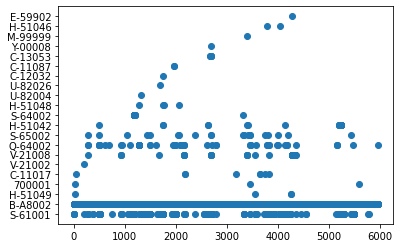

5959 528955


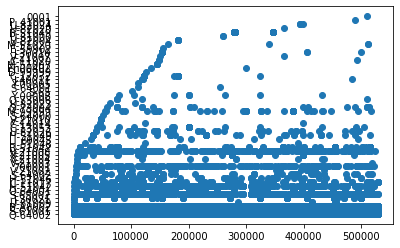

dict_keys(['Q-64002', 'S-61001', 'B-A8002', 'U-81009', 'J-30021', 'S-65002', 'Q-64001', 'H-51042', 'C-11017', 'H-51046', 'S-64002', 'V-21002', '700001', 'V-21003', 'V-21004', 'V-21005', 'V-21008', 'B-51042', 'H-51048', '60045', 'H-51049', 'U-82026', 'C-13053', 'C-14014', 'V-21010', 'S-64000', 'M-99999', 'Q-73004', 'U-82023', 'Q-73006', 'Y-00008', 'S-65', 'S-64001', 'Y-00005', 'J-40011', 'C-12032', 'D-99999', 'En00402', 'M-51007', 'C-11020', 'V-21007', 'J-30010', 'E-59902', 'M-51020', 'U-82004', 'U-81000', 'B-51049', 'U-82020', 'U-82024', 'P_41001', '0001'])
dict_values([267, 5435, 4, 3, 8, 1, 85, 59, 20, 40, 17, 4, 1, 1, 1, 2, 6, 1, 1, 2, 1])
dict_values([9042, 18694, 496804, 6, 339, 1120, 144, 371, 104, 61, 56, 30, 212, 4, 9, 42, 276, 76, 3, 6, 378, 52, 31, 3, 40, 1, 46, 21, 2, 5, 9, 1, 2, 1, 4, 32, 1, 2, 5, 3, 2, 26, 1, 4, 5, 2, 870, 1, 4, 1, 1])


In [ ]:
plotli2=[] #problem없는

ERRTYP=5
sum=0
for i in range(15000):
    if (cntmy[i]>0):
        sum+=1
        continue
    else:
        first,last =idarr[i]
        for i in range(first,last+1):
            uid,dtime,fw,errty,errco = id_error[i]
            if errty==ERRTYP:
                    plotli2.append(errco)
print(sum)
sum=0
plotli=[] #problem있는
for i in range(15000):
    for j in range(cntmy[i]):
        sum+=1
        errt=timeprob[i][j][2]
        errc=timeprob[i][j][3]
        #print(errt)
        for idx,val in enumerate(errt):
            if val==ERRTYP:
                plotli.append(errc[idx])
print("errortype=",ERRTYP)
print("no problem",sum)
for i,val in enumerate(plotli):
    plotli[i]=val.strip()
for i,val in enumerate(plotli2):
    plotli2[i]=str(val).strip()    
print("problem O")
t1=np.arange(0,len(plotli))
plt.scatter(t1,plotli)
plt.show()
print(len(plotli),len(plotli2))
t2=np.arange(0,len(plotli2))
plt.scatter(t2,plotli2)
plt.show()


#words = ['a', 'b', 'c', 'a']

#Counter(words).keys() # equals to list(set(words))
#Counter(words).values() # counts the elements' frequency
Counter(plotli2).keys() # equals to list(set(words))
Counter(plotli2).values() # counts the elements' frequency
print(Counter(plotli2).keys())
print(Counter(plotli).values())
print(Counter(plotli2).values())

In [ ]:


#words = ['a', 'b', 'c', 'a']

#Counter(words).keys() # equals to list(set(words))
#Counter(words).values() # counts the elements' frequency
Counter(plotli2).keys() # equals to list(set(words))
Counter(plotli2).values() # counts the elements' frequency
print(Counter(plotli2).keys())
print(Counter(plotli2).values())
print( "connection fail to establish" in ['active', 'standby', 'UNKNOWN', 'connection fail to establish', 'connectionterminated by local host', 'terminate by peer user', 'connection fail for LMP response timout'])

dict_keys(['Q-64002', 'S-61001', 'B-A8002', 'U-81009', 'J-30021', 'S-65002', 'Q-64001', 'H-51042', 'C-11017', 'H-51046', 'S-64002', 'V-21002', '700001', 'V-21003', 'V-21004', 'V-21005', 'V-21008', 'B-51042', 'H-51048', '60045', 'H-51049', 'U-82026', 'C-13053', 'C-14014', 'V-21010', 'S-64000', 'M-99999', 'Q-73004', 'U-82023', 'Q-73006', 'Y-00008', 'S-65', 'S-64001', 'Y-00005', 'J-40011', 'C-12032', 'D-99999', 'En00402', 'M-51007', 'C-11020', 'V-21007', 'J-30010', 'E-59902', 'M-51020', 'U-82004', 'U-81000', 'B-51049', 'U-82020', 'U-82024', 'P_41001', '0001'])
dict_values([9042, 18694, 496804, 6, 339, 1120, 144, 371, 104, 61, 56, 30, 212, 4, 9, 42, 276, 76, 3, 6, 378, 52, 31, 3, 40, 1, 46, 21, 2, 5, 9, 1, 2, 1, 4, 32, 1, 2, 5, 3, 2, 26, 1, 4, 5, 2, 870, 1, 4, 1, 1])
True


#errlist만들기


In [ ]:
errlistprob=np.zeros((5500,152))
labprob=np.zeros((5500))
cindex=0
templi=[]
curuser=-1
for i in range(15000):
    for j in range(cntmy[i]):
        temp=timeprob[i][j]
        #print(temp[2])
        for k in range(len(temp[2])):
            if temp[2][k]==23:
                if temp[3][k].strip() in ['standby']:
                    errlistprob[cindex,42]+=1
                elif temp[3][k].strip() in ['connection fail to establish']:
                    errlistprob[cindex,28]+=1
                elif temp[3][k].strip() in ['connection timeout']:
                    errlistprob[cindex,43]+=1
                elif temp[3][k].strip() in ['active']:
                    errlistprob[cindex,44]+=1
                elif temp[3][k].strip() in ['connectionterminated by local host']:
                    errlistprob[cindex,45]+=1
                elif temp[3][k].strip() in ['terminate by peer user']:
                    errlistprob[cindex,46]+=1
            elif temp[2][k]==31:
                if str(temp[3][k]).strip() in ['1']:
                    errlistprob[cindex,47]+=1
                if str(temp[3][k]).strip() in ['0']:
                    errlistprob[cindex,48]+=1
            elif temp[2][k]==4:
                if str(temp[3][k]).strip() in ['0']:
                    errlistprob[cindex,49]+=1
                elif str(temp[3][k]).strip() in ['1']:
                    errlistprob[cindex,50]+=1
            elif temp[2][k]==40:
                if str(temp[3][k]).strip() in ['0']:
                    errlistprob[cindex,51]+=1
                elif str(temp[3][k]).strip() in ['1']:
                    errlistprob[cindex,52]+=1
            elif temp[2][k]==1:
                if str(temp[3][k]).strip() in ['0']:
                    errlistprob[cindex,53]+=1
                elif str(temp[3][k]).strip() in ['1']:
                    errlistprob[cindex,54]+=1
            if temp[2][k]==33:
                if str(temp[3][k]).strip() in ['2']:
                    errlistprob[cindex,55]+=1
                elif str(temp[3][k]).strip() in ['3']:
                    errlistprob[cindex,56]+=1
                elif str(temp[3][k]).strip() in ['1']:
                    errlistprob[cindex,57]+=1
            if temp[2][k]==14:
                if str(temp[3][k]).strip() in ['13']:
                    errlistprob[cindex,58]+=1
                elif str(temp[3][k]).strip() in ['14']:
                    errlistprob[cindex,59]+=1
                elif str(temp[3][k]).strip() in ['1']:
                    errlistprob[cindex,60]+=1
            elif temp[2][k]==16: #['80', '79', '81', '78', '85', '84', '90', '89', '88', '95', '94', '91', '83', '86', '87', '82', '93', '77', '75', '76', '96', '92', '100'
                for idx,val in enumerate(li16):
                    if str(temp[3][k]).strip()==val:
                        errlistprob[cindex,61+idx]+=1
                        break
            elif temp[2][k]==5:
                for idx,val in enumerate(li5):
                    if str(temp[3][k]).strip()==val:
                        errlistprob[cindex,126+idx]+=1
                        break    
            errlistprob[cindex,temp[2][k]-1]+=1

        if(len(Counter(temp[4]).keys()) >1):
            errlistprob[cindex,84]+=1
        if( len(temp[4]) !=0):
            errlistprob[cindex,85]=fwint(temp[4][0])
        for k in range(len(temp[6])):
            errlistprob[cindex,86+k]=temp[6][k]

        labprob[cindex]+=1
        cindex+=1        



In [ ]:
id_qual[0]

array([10000, Timestamp('2020-11-29 09:00:00'), '05.15.2138', 0.0, 0, 0.0,
       0, 0, 0.0, 0, 0, 0, 0, 4, 0, 0], dtype=object)

In [ ]:
'''
li2=np.arange(0,13,1)
timeerror=3
sum=0
for i in range(15000):
    if idqualarr[i]!=[]:
        first,last=idqualarr[i]
        for j in range(first,last+1):
            qualval=id_qual[j]
            timeid=qualval[1]
            if( timeid+datetime.timedelta(hours=timeerror*-1) <dtime< timeid+datetime.timedelta(hours=timeerror)):
                sum+=1
print(sum)
'''

'\nli2=np.arange(0,13,1)\ntimeerror=3\nsum=0\nfor i in range(15000):\n    if idqualarr[i]!=[]:\n        first,last=idqualarr[i]\n        for j in range(first,last+1):\n            qualval=id_qual[j]\n            timeid=qualval[1]\n            if( timeid+datetime.timedelta(hours=timeerror*-1) <dtime< timeid+datetime.timedelta(hours=timeerror)):\n                sum+=1\nprint(sum)\n'

In [ ]:
print(cindex)
print(len(error))
print(temp[4][0])

5429
15000
04.22.1778


In [ ]:
totalerror=np.zeros((20430,152))
labelprob=np.zeros((20430))
cindex=0
for i in range(len(error)):
    for j in range(0,126):
        totalerror[cindex,j]=error[i,j]
    labelprob[cindex]=problem[i]
    cindex+=1
print(cindex)
for i in range(5429):
    for j in range(0,126):
        totalerror[cindex,j]=errlistprob[i,j]
    labelprob[cindex]=problem[i]
    cindex+=1
    


15000


In [ ]:
cindex

20429

#2.42 weightli만들기
가중치 줘서 트레이닝시켜보기


In [ ]:
#weight list구하기
weightli=[1]*23430
#numerr=800
discount=0.3
cnt=0
sum=0
for i,val in enumerate(error):
    cnt=0
    for j in val:
        cnt+=j
    if i>15000:
        weightli[i]+=0
        '''
    elif (cnt>numerr):
        sum+=1
        weightli[i]-=discount
    
print(sum)
'''

In [ ]:
'''
errlistprob=np.zeros((5500,42))
cindex=0
for idx,val in enumerate(timeprob):
      if idx == 2:
          break
      else:
          print(val)
for idx,val in enumerate(timeprob):
    if (type(val[0][0])==int):
        continue
    numofp=cntmy[idx]
    for i in range(numofp):
        for j in val[2]:
            print(val)
            errlistprob[cindex,j-1]+=1
        cindex+=1
'''

'\nerrlistprob=np.zeros((5500,42))\ncindex=0\nfor idx,val in enumerate(timeprob):\n      if idx == 2:\n          break\n      else:\n          print(val)\nfor idx,val in enumerate(timeprob):\n    if (type(val[0][0])==int):\n        continue\n    numofp=cntmy[idx]\n    for i in range(numofp):\n        for j in val[2]:\n            print(val)\n            errlistprob[cindex,j-1]+=1\n        cindex+=1\n'

#2.4 quality data가져오기

# 2.5 validation set 만들기


In [ ]:
'''
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val= train_test_split(errstrli,problem, test_size=0.1,shuffle=True,random_state=1004)
print("validation set shape=",x_val.shape,y_val.shape) #1500개의 validation set

print(x_train[15],y_train[15])
'''

'\nfrom sklearn.model_selection import train_test_split\n\nx_train, x_val, y_train, y_val= train_test_split(errstrli,problem, test_size=0.1,shuffle=True,random_state=1004)\nprint("validation set shape=",x_val.shape,y_val.shape) #1500개의 validation set\n\nprint(x_train[15],y_train[15])\n'

#2.6 Embedding layer만들기
The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings)
https://www.tensorflow.org/tutorials/text/word_embeddings?hl=en

즉, 각각의 error type을 dense vector로 바꿔주는 것이 
embedding layer이며, dimentionality (width) 를 조정하면서
내 문제에 잘 맞는지 확인할 수 있다.
Dense layer에 node를 몇개 둘 것인지 계속 바꿔나가는 것 과 같이.
``` python
# Embed a 1,000 word vocabulary into 5 dimensions.
embedding_layer = tf.keras.layers.Embedding(1000, 5)
```
### 방안
1. 단순하게 생각하면, 우린 42개의 error type이 있다고 볼 수 있다. 고로 42개의 error type 각각을 dense vector로 바꿔주면 되지 않을까?
고로, embedding_layer을 다음과같이만들어보자.
2. 아니면 42개의 error type이 있는건 맞지만, 되게 다양한 state에서의 error type이존재하기도 한다. 즉 1번 에러 뒤에오는 2번이라던지?
근데 경우의 수가 너무 많아지고 본래도 비슷할 것 같다
왜냐하면 word도 앞에나올수도 있고 뒤에 나올 수도 있기 때문

지금 sequence dimension이라는 것은
5 이런거. 우리가 5차원으로 뒀지.
1000개의 sequence가 있어 위 예제에는.

### 2.7 layer에 넣는작업

layer에 넣으려면 errli[0]은 317개의 err type 즉, 317개의 5차원 seqeuence가 존재할테고
errli[1]은 뭐 몇개 이런식으로 존재할텐데
그 개수를 통일시키기 위해서
global Average Pooling 1D layer을 두면, 317개의 5차원 sequence들의 평균을 이용해서 둘 수 도 있고,
RNN 을 이용할 수도 있어.
일단 global Average Pooling 1D

#2.5 word embedding



# 3. Light-gbm 모델 훈련

In [ ]:
# 변수 이름 변경
# error  -> train_x
# problem-> train_y
#totalerror labelprob
#train_x = error
#train_y = problem
train_x = totalerror
train_y = labelprob
origtrain_x=error
origtrain_y=problem
weightnpli=np.array(weightli)
#del error, problem
print(train_x.shape)
print(train_y.shape)
print(weightnpli.shape)
print(origtrain_x.shape,origtrain_y.shape)

(20430, 152)
(20430,)
(23430,)
(15000, 152) (15000,)


In [ ]:
train_x[0][31]


0.0

In [ ]:
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------

paramnw={'num_leaves':200,#100
       'min_data_in_leaf':30,
       'objective':'binary',
       'max_depth':11 , #6 10
       'learning_rate':0.005 ,#'learning_rate':0.02 ,
       'boosting':"gbdt",
       "feature_fraction":0.9, #0.7522
       "bagging_freq":1,
       "bagging_fraction":0.7083,
       "bagging_seed":11,
       "metric":"rmse",
       "random_state":133
       }
params = {'learning_rate': 0.005,
              'max_depth': 16,
              'boosting': 'gbdt',
              'objective': 'binary',
              'metric': 'auc',
               #'is_training_metric': True,\n",
             'num_leaves': 144,
              'feature_fraction': 0.9,
              'bagging_fraction': 0.7,
              'bagging_freq': 5,
              'seed':2020}

models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'boosting_type' : 'gbdt',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015
                }
#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
'''
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(origtrain_x):
    X=origtrain_x[train_idx]
    y=origtrain_y[train_idx]
    valid_x=origtrain_x[val_idx]
    valid_y=origtrain_y[val_idx]   
    d_train=lgb.Dataset(X,y)
    d_val = lgb.Dataset(valid_x,valid_y)
    model2 = lgb.train(
                        paramnw,
                        train_set       = d_train,
                        num_boost_round = 1000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 200
                       )
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)
    print('==========================================================')
'''
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(train_x):
    X=train_x[train_idx]
    y=train_y[train_idx]
    weightnplis=weightnpli[train_idx]
    valid_x=train_x[val_idx]
    valid_y=train_y[val_idx]
    d_train=lgb.Dataset(X,y, weight=weightnplis)
    d_val = lgb.Dataset(valid_x,valid_y)

    #run traning
    model = lgb.train(
                        paramnw,
                        train_set       = d_train,
                        num_boost_round = 1000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 300
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

[20]	valid_0's rmse: 0.460487	valid_0's pr_auc: 0.621359
[40]	valid_0's rmse: 0.461959	valid_0's pr_auc: 0.618251
[60]	valid_0's rmse: 0.463993	valid_0's pr_auc: 0.617088
[80]	valid_0's rmse: 0.47132	valid_0's pr_auc: 0.61732
[100]	valid_0's rmse: 0.468726	valid_0's pr_auc: 0.618615
[120]	valid_0's rmse: 0.464652	valid_0's pr_auc: 0.619764
[140]	valid_0's rmse: 0.460868	valid_0's pr_auc: 0.620735
[160]	valid_0's rmse: 0.459779	valid_0's pr_auc: 0.620009
[180]	valid_0's rmse: 0.457933	valid_0's pr_auc: 0.620366
[200]	valid_0's rmse: 0.454878	valid_0's pr_auc: 0.620137
[220]	valid_0's rmse: 0.454802	valid_0's pr_auc: 0.621211
[240]	valid_0's rmse: 0.453773	valid_0's pr_auc: 0.621906
[260]	valid_0's rmse: 0.452829	valid_0's pr_auc: 0.621951
[280]	valid_0's rmse: 0.450112	valid_0's pr_auc: 0.620898
[300]	valid_0's rmse: 0.450318	valid_0's pr_auc: 0.620832
[320]	valid_0's rmse: 0.448582	valid_0's pr_auc: 0.621372
[340]	valid_0's rmse: 0.445713	valid_0's pr_auc: 0.620748
[360]	valid_0's rmse

# 4. 교차검증 점수 확인

In [ ]:
print(np.mean(auc_scores)) #0.7459298202316195 0.8066887653152083 #0.77893 0.780559 depth 11 0.780628
# 0.8072759477430488 0.746440183016864 0.7471924683182276 0.7475194696987806 #0.7534156010437357(젤높은거)

0.7491021375975487


# 5. 제출 파일 생성

In [ ]:
test_err  = pd.read_csv(PATH+'test_err_data.csv')
display(test_err.head())
print(test_err.fwver.unique())

,user_id,time,model_nm,fwver,errtype,errcode
0,30000,20201101030227,model_1,04.16.3553,31,1
1,30000,20201101030227,model_1,04.16.3553,33,2
2,30000,20201101030228,model_1,04.16.3553,15,1
3,30000,20201101030256,model_1,04.16.3553,22,1
4,30000,20201101030300,model_1,04.16.3553,11,1


['04.16.3553' '04.16.3571' '04.33.1261' '05.15.2138' '04.22.1750'
 '04.22.1778' '04.33.1149' '03.11.1167' '04.33.1185' '04.22.1684'
 '05.15.2120' '04.82.1684' '04.82.1778' '10' '05.66.3237' '04.73.2569'
 '04.73.2571' '04.73.2237' '04.73.2577' '04.82.1730' '04.22.1478' '8.5.3'
 '04.22.1666' '04.22.1656' '03.11.1149' '04.33.1171' '05.66.3571'
 '04.16.3439' '05.15.2092' '03.11.1141' '04.22.1608' '05.15.3104'
 '04.33.1125' '04.22.1448' '05.15.2114' '10.22.1770' '10.22.1780'
 '04.16.3569' '04.22.1772' '04.22.1170']


In [ ]:
# 데이터 설명을 확인하면
# test 데이터는 ueser_id가 30000부터 44998까지 총 14999개가 존재.
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999
test_err['datetime'] = test_err['time'].apply(make_datetime)
id_error = test_err[['user_id','datetime','fwver','errtype','errcode']].values
#fulltest_x=np.zeros((test_user_number,42))
test_x = np.zeros((test_user_number,152))


In [ ]:
train_qual = pd.read_csv(PATH+'test_quality_data.csv',thousands=',')
train_qual['datetime'] = train_qual['time'].apply(make_datetime)

id_qual=train_qual[['user_id','datetime','fwver','quality_0','quality_1','quality_2','quality_3','quality_4','quality_5','quality_6','quality_7','quality_8','quality_9','quality_10','quality_11','quality_12']].values
qualili=np.zeros((15000,14))
cnt=0

curuser=30000
cnt=0
#qualist=([10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,-500,-500,-500,-500,-500,-500,-500,-500,-500,-500,-500,-500,-500])*15000
qualist=np.zeros((15000,26))
for i in qualist:
    for j in range(13):
        i[j]=100000000
    for j in range(13,26):
        i[j]=-500

min=1000000000
max=-500
for j in tqdm(id_qual):
    if curuser==j[0]:
        for i in range(3,16):
          if( qualist[curuser-30000][i-3]>j[i]):
              qualist[curuser-30000][i-3]=j[i]
          elif (qualist[curuser-30000][i-3+13]<j[i]):
              qualist[curuser-30000][i-3+13]=j[i]
    else:
        curuser=j[0]
        for i in range(3,16):
          if( qualist[curuser-30000][i-3]>j[i]):
              qualist[curuser-30000][i-3]=j[i]
          elif (qualist[curuser-30000][i-3+13]<j[i]):
              qualist[curuser-30000][i-3+13]=j[i]

#for user,dat,fw,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12 in tqdm(id_qual):
print(curuser)
newqualist=np.zeros((15000,13))
for i in range(15000):
    for j in range(13):
        if (qualist[i][j+13]-qualist[i][j] <-5000): #초기값
            continue
        else:
            newqualist[i][j]=qualist[i][j+13]-qualist[i][j]

   


100%|██████████| 747972/747972 [00:13<00:00, 55130.64it/s]


44997


In [ ]:
person,timeid=id_qual[0][0],id_qual[0][1]
person,timeid
print(person,timeid)
ab=[]
#print(id_errtime[0],id_errtime[500])# 10000 번째, 10001번쨰 두명있네.
curuser=30000
first=0
last=0
cnt=0
idqualarr=[]
for user,dat,fw,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12 in tqdm(id_qual):
    if (curuser==user):
        last=cnt
    else:
        li=[]
        li.append(first)
        li.append(last)        
        idqualarr.append(li)
        ab.append(curuser)
        for i in range(curuser+1,user):
            idqualarr.append([])
            ab.append(i)
        first=cnt
        curuser=user
    cnt+=1

li=[]
li.append(first)
li.append(last)
idqualarr.append(li)
idqualarr.append([])
#idqualarr.append([])

  7%|▋         | 54378/747972 [00:00<00:01, 543776.63it/s]

30000 2020-11-28 19:00:00


100%|██████████| 747972/747972 [00:01<00:00, 587196.97it/s]


In [ ]:
print(len(idqualarr))
print(user)

In [ ]:
id_error = test_err[['user_id','datetime','fwver','errtype','errcode']].values
#error = np.zeros((test_user_number,126)) #14999,42 의 0배열 생성.
#errorreduc=np.zeros((train_user_number,32))
minnum=317
curuser=30000
#errstrli=np.zeros((train_user_number,1),dtype="object")

#errli=np.empty((train_user_number,1),dtype="object")
sum=0
allnum=0
color=0
temp=[]
#usid,dtime,fw,erty,errco
cnt=0
li16=['80', '79', '81', '78', '85', '84', '90', '89', '88', '95', '94', '91', '83', '86', '87', '82', '93', '77', '75', '76', '96', '92', '100']
for person_idx,dtime,fw,err,errco in tqdm(id_error):
    #print(person_idx)
    if err==23:
        if errco.strip() in ['standby']:
            test_x[person_idx-test_user_id_min,42]+=1
        elif errco.strip() in ['connection fail to establish']:
            test_x[person_idx-test_user_id_min,28]+=1
        elif errco.strip() in ['connection timeout']:
            test_x[person_idx-test_user_id_min,43]+=1
        elif errco.strip() in ['active']:
            test_x[person_idx-test_user_id_min,44]+=1
        elif errco.strip() in ['connectionterminated by local host']:
            test_x[person_idx-test_user_id_min,45]+=1
        elif errco.strip() in ['terminate by peer user']:
            test_x[person_idx-test_user_id_min,46]+=1
    elif err==31:
        if str(errco).strip() in ['1']:
            test_x[person_idx-test_user_id_min,47]+=1
        if str(errco).strip() in ['0']:
            test_x[person_idx-test_user_id_min,48]+=1
    elif err==4:
        if str(errco).strip() in ['0']:
            test_x[person_idx-test_user_id_min,49]+=1
        elif str(errco).strip() in ['1']:
            test_x[person_idx-test_user_id_min,50]+=1
    elif err==40:
        if str(errco).strip() in ['0']:
            test_x[person_idx-test_user_id_min,51]+=1
        elif str(errco).strip() in ['1']:
            test_x[person_idx-test_user_id_min,52]+=1
    elif err==1:
        if str(errco).strip() in ['0']:
            test_x[person_idx-test_user_id_min,53]+=1
        elif str(errco).strip() in ['1']:
            test_x[person_idx-test_user_id_min,54]+=1
    if err==33:
        if str(errco).strip() in ['2']:
            test_x[person_idx-test_user_id_min,55]+=1
        elif str(errco).strip() in ['3']:
            test_x[person_idx-test_user_id_min,56]+=1
        elif str(errco).strip() in ['1']:
            test_x[person_idx-test_user_id_min,57]+=1
    if err==14:
        if str(errco).strip() in ['13']:
            test_x[person_idx-test_user_id_min,58]+=1
        elif str(errco).strip() in ['14']:
            test_x[person_idx-test_user_id_min,59]+=1
        elif str(errco).strip() in ['1']:
            test_x[person_idx-test_user_id_min,60]+=1
    elif err==16: #['80', '79', '81', '78', '85', '84', '90', '89', '88', '95', '94', '91', '83', '86', '87', '82', '93', '77', '75', '76', '96', '92', '100'
        for idx,val in enumerate(li16):
            if str(errco).strip()==val:
                test_x[person_idx-test_user_id_min,61+idx]+=1
                break
    elif err==5:
        for idx,val in enumerate(li5):
            if str(errco).strip()==val:
                test_x[person_idx-test_user_id_min,126+idx]+=1
                break
    if(curuser==person_idx):
        temp.append(fw)
    else:
        if(len(Counter(temp).keys()) >1):
            test_x[person_idx-test_user_id_min,84]+=1
        test_x[person_idx-test_user_id_min,85]=fwint(temp[0])
        temp=[]
        curuser=person_idx
        temp.append(fw)
        
    
    test_x[person_idx - test_user_id_min,err - 1] += 1

    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1  그래서 [사람idx,error type] 번째에 +=1 되는건데, errtype이 1~42니까 -1 해서 errtype의 min은 0번부터시작, person도 0번부터 시작
if(len(Counter(temp).keys()) >1):
    test_x[person_idx-test_user_id_min,84]+=1
test_x[person_idx-test_user_id_min,85]=fwint(temp[0])

100%|██████████| 16532648/16532648 [00:53<00:00, 311257.40it/s]


In [ ]:
max=-1
li2=np.arange(0,13,1)
for i in range(14999):
    if idqualarr[i]!=[]:
        first,last=idqualarr[i]
        meanarr=np.zeros((last+1-first,13))
        cindex=0
        for j in range(first,last+1):
            qualval=id_qual[j]
            for k in range(3,16):
              meanarr[cindex,k-3]=qualval[k]
            cindex+=1
        df=pd.DataFrame(meanarr,columns=li2)
        listd=df.std()
        limean=df.mean()
        for j in range(0,13):
            test_x[i,99+j]=limean[j]
            test_x[i,99+j+13]=listd[j]
            #qualstd[i,j]=limean[j]
            #qualstd[i,j+13]=listd[j]
for i in range(14999):
    for j in range(13):
        test_x[i,86+j]=newqualist[i,j]


In [ ]:
'''
curuser=30000
for  person_idx,dtime,fw,err,errco in tqdm(id_error):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    if errco in ['standby']:
        continue
    test_x[person_idx - test_user_id_min,err - 1] += 1
    #test_x[person_idx-test_user_id_min,err-1]+=1
    #fulltest_x[person_idx-test_user_id_min,42]=fwint(fw)
    #if (err in errdic):
     #   test_x[person_idx - test_user_id_min, errdic[err]]+=1
     #   test_x[person_idx-test_user_id_min,31]=fwint(fw)
#fulltest_x=test_x.reshape(fulltest_x.shape[0],-1)
test_x = test_x.reshape(test_x.shape[0],-1)
print(test_x.shape)
'''

In [ ]:
# 예측
pred_y_list = []
for model in models:
    pred_y = model.predict(test_x)
    #pred_y = model.predict(fulltest_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)


In [ ]:
pred_ensemble
#

array([[0.89541817],
       [0.34314991],
       [0.50836294],
       ...,
       [0.7363002 ],
       [0.79382683],
       [0.3917885 ]])

In [ ]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')

In [ ]:
sample_submssion['problem'] = pred_ensemble.reshape(-1)

In [ ]:
sample_submssion.to_csv("byeon_highestwith128paramwith11depthfeafrac allsameweight.csv", index = False)
sample_submssion

,user_id,problem
0,30000,0.895418
1,30001,0.343150
2,30002,0.508363
3,30003,0.717533
4,30004,0.655876
...,...,...
14994,44994,0.192958
14995,44995,0.300698
14996,44996,0.736300
14997,44997,0.793827


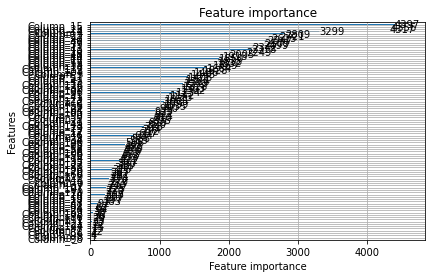

In [ ]:
lgb.plot_importance(model)
plt.show()
feature_importance=pd.DataFrame([model.feature_name(),model.feature_importance()]).T
feature_importance.columns=["features","varimp"]
feature_importance=feature_importance.sort_values(["varimp"],ascending=False)
feature_importance.head()
feature_importance.to_csv("128paramimportance.csv",index=False)

정확도 *0.82269* 109위. 종료.
https://dacon.io/competitions/official/235687/leaderboard/
